In [20]:
import sys
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import itertools
try:
    from vlmeval.smp import *
except ImportError:
    sys.path.append('../vlmeval/')
    from smp import *

font_URL = 'http://opencompass.openxlab.space/utils/Fonts/segoepr.ttf'
download_file(font_URL)

font12 = fm.FontProperties(fname='segoepr.ttf', size=12)
font15 = fm.FontProperties(fname='segoepr.ttf', size=15, weight='bold')
font18 = fm.FontProperties(fname='segoepr.ttf', size=18, weight='bold')

MMBench_URL = 'http://opencompass.openxlab.space/utils/MMBench.json'
MMLB_URL = 'http://opencompass.openxlab.space/utils/MMLB.json'
download_file(MMBench_URL)
download_file(MMLB_URL)

pass

segoepr.ttf: 172kB [00:00, 878kB/s]                            
MMBench.json: 73.7kB [00:00, 977kB/s]
MMLB.json: 16.4kB [00:00, 410kB/s]


In [21]:
def pre_normalize(raw_data, labels):
    data_list = cp.deepcopy(raw_data)
    minimum, maximum, max_range, range_map = {}, {}, 0, {}
    for lb in labels:
        minimum[lb] = min([x[lb] for x in data_list])
        maximum[lb] = max([x[lb] for x in data_list])
        max_range = max(max_range, maximum[lb] - minimum[lb])
    max_range *= 1.25
    for lb in labels:
        mid = (minimum[lb] + maximum[lb]) / 2
        new_range = (mid - max_range / 2, mid + max_range / 2) if (mid + max_range / 2) < 100 else (100 - max_range, 100)
        range_map[lb] = new_range
        for item in data_list:
            assert new_range[0] <= item[lb] <= new_range[1]
            item[lb] = (item[lb] - new_range[0]) / max_range * 100
    return data_list, range_map

In [22]:
# Draw MMBench Radar Graph
split = 'MMBench_EN_TEST'
data = load('MMBench.json')
data = {k: v for k, v in data.items() if split in v}
for k in data:
    item = {kk: float(vv) for kk, vv in data[k][split].items()}
    item.update(dict(Model=k))
    data[k] = item
    
models = list(data)
models.sort(key=lambda x: -data[x]['Overall'])
print(models)

model2vis = [
    'GPT-4v (detail: low)', 'GeminiProVision', 'Qwen-VL-Plus', 
    'InternLM-XComposer-VL', 'LLaVA-v1.5-13B', 'CogVLM-17B-Chat',
    'mPLUG-Owl2', 'Qwen-VL-Chat', 'IDEFICS-80B-Instruct'
]
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
    '#e377c2', '#7f7f7f', '#bcbd22'
]

['Qwen-VL-Plus Base', 'Marco-VL-34B', 'AntGMM-Chat', 'GPT-4v (detail: low)', 'Pink', 'Kanva-14B', 'InternLM-XComposer-VL', 'GeminiProVision', 'Marco-VL-13B', 'Marco-VL-6B', 'JiuTian', 'TransCore-M', 'RBDash-v1-13B', 'Sphinx-V2', 'Prompt Highlighter', 'EasyGen', 'LLaVA-InternLM-7B (LoRA)', 'WeMM', 'StableLLaVA-13B', 'LLaVA-v1.5-13B (LoRA, XTuner)', 'LLaVA-v1.5-13B', 'LLaVA-v1.5-7B (LoRA, XTuner)', 'Kanva-7B', 'Sphinx', 'Qwen-VL-Plus', 'SharedCaptioner', 'ShareGPT4V-7B', 'mPLUG-Owl2', 'CogVLM-17B-Chat', 'LLaVA-v1.5-7B', 'MMICL', 'LMEye', 'Qwen-VL-Chat', 'JiuTian-Tiny', 'Shikra', 'IDEFICS-80B-Instruct', 'Otter-I', 'IDEFICS-9B-Instruct', 'PandaGPT-13B', 'LLaVA-v1-7B', 'G2PT', 'LLaMA-Adapter-v2', 'VisualGLM', 'InstructBLIP-7B', 'Qwen-VL', 'LAMM', 'MiniGPT-4-v1-7B', 'MMGPT', 'MiniGPT-4-v2', 'OpenFlamingo v2', 'OpenFlamingo']


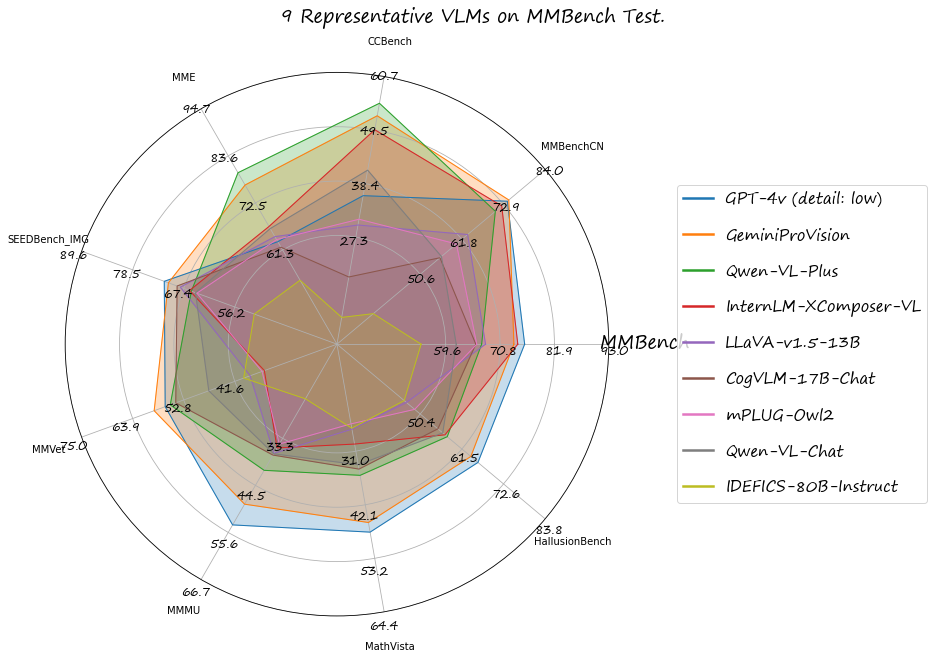

In [27]:
labels = list(data[model2vis[0]])
labels = [x for x in labels if x not in ['Model', 'Overall']]
num_vars = len(labels)

raw_data = [data[m] for m in model2vis]
data_list, range_map = pre_normalize(raw_data, labels)

alpha = 0.25
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_deg = np.linspace(0, 360, num_vars, endpoint=False).tolist()
fig, ax_base = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), subplot_kw=dict(polar=True))

for i in range(len(data_list)):
    item = data_list[i]
    model_name = item['Model']
    color = colors[i]
    tmp_angles = angles[:] + [angles[0]]
    tmp_values = [item[lb] for lb in labels] + [item[labels[0]]]
    ax_base.plot(tmp_angles, tmp_values, color=color, linewidth=1, linestyle='solid', label=model_name)
    ax_base.fill(tmp_angles, tmp_values, color=color, alpha=alpha)
    
angles += [angles[0]]
ax_base.set_ylim(0, 100)
ax_base.set_yticks([40, 60, 80, 100])
ax_base.set_yticklabels([''] * 4)

ax_base.tick_params(pad=25)
ax_base.set_xticks(angles[:-1])
ax_base.set_xticklabels(labels, fontproperties=font18)

leg = ax_base.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), prop=font15, ncol=1, frameon=True, labelspacing=1.2)
for line in leg.get_lines():
    line.set_linewidth(2.5)

cx, cy, sz = 0.44, 0.435, 0.34
axes = [fig.add_axes([cx - sz, cy - sz, cx + sz, cy + sz], projection='polar', label='axes%d' % i) for i in range(num_vars)]
    
for ax, angle, label in zip(axes, angles_deg, labels):
    ax.patch.set_visible(False)
    ax.grid(False)
    ax.xaxis.set_visible(False)
    cur_range = range_map[label]
    label_list = [cur_range[0] + (cur_range[1] - cur_range[0]) / 5 * i for i in range(2, 6)]
    label_list = [f'{x:.1f}' for x in label_list]
    ax.set_rgrids(range(40, 120, 20), angle=angle, labels=label_list, font_properties=font12)
    ax.spines['polar'].set_visible(False)
    ax.set_ylim(0, 100)

title_text = f'{len(model2vis)} Representative VLMs on MMBench Test.'
plt.figtext(.7, .95, title_text, fontproperties=font18, ha='center')
plt.show()

In [28]:
data = load('MMLB.json')
for k in data:
    pop_list = ['Parameters', 'Language Model', 'Vision Model', 'Org', 'Time', 'Verified', 'OpenSource', 'URL', 'Avg Score', 'Avg Rank']
    for p in pop_list:
        data[k].pop(p)
    data[k]['Model'] = k

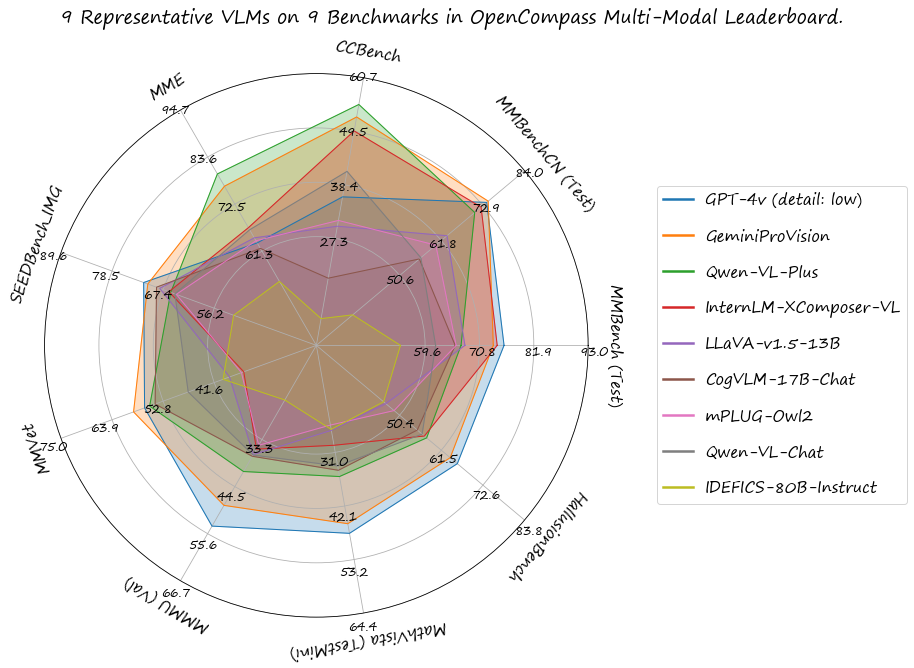

In [26]:
labels = list(data[model2vis[0]])
labels = [x for x in labels if x not in ['Model', 'Overall']]
num_vars = len(labels)

raw_data = [data[m] for m in model2vis]
data_list, range_map = pre_normalize(raw_data, labels)

alpha = 0.25
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_deg = np.linspace(0, 360, num_vars, endpoint=False).tolist()
fig, ax_base = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), subplot_kw=dict(polar=True))

for i in range(len(data_list)):
    item = data_list[i]
    model_name = item['Model']
    color = colors[i]
    tmp_angles = angles[:] + [angles[0]]
    tmp_values = [item[lb] for lb in labels] + [item[labels[0]]]
    ax_base.plot(tmp_angles, tmp_values, color=color, linewidth=1, linestyle='solid', label=model_name)
    ax_base.fill(tmp_angles, tmp_values, color=color, alpha=alpha)
    
angles += [angles[0]]
ax_base.set_ylim(0, 100)
ax_base.set_yticks([40, 60, 80, 100])
ax_base.set_yticklabels([''] * 4)

ax_base.tick_params(pad=15)
ax_base.set_xticks(angles[:-1])
ax_base.set_xticklabels(labels, fontproperties=font18)

dataset_map = {
    'MMBench': 'MMBench (Test)', 
    'MMBenchCN': 'MMBenchCN (Test)', 
    'MathVista': 'MathVista (TestMini)', 
    'MMMU': 'MMMU (Val)'
}
for i, label in enumerate(ax_base.get_xticklabels()):
    x,y = label.get_position()
    text = label.get_text()
    text = dataset_map[text] if text in dataset_map else text
    lab = ax_base.text(x, y, text, transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va(), font_properties=font15)
    lab.set_rotation(360 / num_vars * i + 270)
    labels.append(lab)
ax_base.set_xticklabels([])

leg = ax_base.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), prop=font15, ncol=1, frameon=True, labelspacing=1.2)
for line in leg.get_lines():
    line.set_linewidth(2.5)

cx, cy, sz = 0.44, 0.435, 0.34
axes = [fig.add_axes([cx - sz, cy - sz, cx + sz, cy + sz], projection='polar', label='axes%d' % i) for i in range(num_vars)]
    
for ax, angle, label in zip(axes, angles_deg, labels):
    ax.patch.set_visible(False)
    ax.grid(False)
    ax.xaxis.set_visible(False)
    cur_range = range_map[label]
    label_list = [cur_range[0] + (cur_range[1] - cur_range[0]) / 5 * i for i in range(2, 6)]
    label_list = [f'{x:.1f}' for x in label_list]
    ax.set_rgrids(range(40, 120, 20), angle=angle, labels=label_list, font_properties=font12)
    ax.spines['polar'].set_visible(False)
    ax.set_ylim(0, 100)

title_text = f'{len(model2vis)} Representative VLMs on {num_vars} Benchmarks in OpenCompass Multi-Modal Leaderboard.'
plt.figtext(.7, .95, title_text, fontproperties=font18, ha='center')
plt.show()